# Retrieving time series geospatial data from a GraphQL query

##### Author: Kathryn Berger, August 2020

### Description

We are interested in retrieving historical mean monthly temperature values for our area of interest, the Rothamsted Research campus. Using our previous example for retrieving static geospatial layers, we will now add mean monthly temperature to our GraphQL query.  

We know from examining our Data Sources from the __[Data Catalogue](https://app.agrimetrics.co.uk/catalog/data-sets)__, that these are time series data at 5km resolution. In this example, we will retrieve the time series data and convert them into a geospatial object (shapefile) to be used in any geographic information system (GIS).

### Importing requirements

In [ ]:
options("Ncpus" = parallel::detectCores())

packages <- c("ggplot2", "httr", "jsonlite", "lubridate", "rgdal", "sf", "sp", "tidyverse")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(
      setdiff(
          packages, 
          rownames(installed.packages())
      ), 
      Ncpus=getOption("Ncpus", 1L),
      INSTALL_opts='--no-lock',
      clean=TRUE
  )  
}

library(ggplot2)
library(httr)
library(jsonlite)
library(lubridate)
library(rgdal)     
library(sf)
library(sp)
library(tidyverse)

### Accessing the data from your geospatial GraphQL query

First, we will require a successful GraphQL query __[here](https://app.agrimetrics.co.uk/graph-explorer
)__ that includes the following: 
* A bounding box for the area of interest to be used as our ***geoFilter***
* For our geospatial query to work, we must have selected ***location*** options in our GraphQL query
* In this case, we have selected to retrieve the ***centroid*** values for each of the geospatialMeasure grid values as observed in the payload shown below
* An ***api-key*** of our own

In [ ]:
options(stringsAsFactors = FALSE)

url = "https://api.agrimetrics.co.uk/graphql"
API_KEY <- Sys.getenv("API_KEY", "UNSET")

# our query searches for soilPH and invertebrate count for area within defined polygon geospatial filter
# below we copy the payload from our GraphQL query using the Rothamsted bounding box for our geoFilter
# note the use added quotations used around the copied GraphQL query for reading into R
# query searches for soilPH, invertebrate count, & mean monthly temp for area within defined polygon geospatial filter
payload <- list(query="query getFieldIdsNearLocation {
  geospatialMeasures(
    geoFilter: {
      location: {
        type: Polygon, 
        coordinates: [[[-0.401073,51.80076],[-0.356222,51.80076],[-0.356222,51.819771],[-0.401073,51.819771],[-0.401073,51.80076]]]
      }
    }
  ) { 
      soilPH { 
        unit 
        value 
        location { 
          centroid 
        } 
      } 
      soilTotalAbundanceOfInvertebrates {
        unit
        value
        location {
          centroid
        }
      }
      temperatureMeanMonthly(
        where: {
          datapoints: {
            date: {
              GE: \"2018-01-01\", LE:\"2018-12-01\"
            }
          }
        }) {
          cursor
          location {
            centroid
          }
          datapoints {
            value
            unit
            dateTime
          }
        }
      }
    }
")
# you will need a subscription key first
# replace "api-key" with your own
r <- POST(url, encode = "json", body = payload, add_headers(
    .headers = c(
        'Accept'="application/json",
        'Ocp-Apim-Subscription-Key'= API_KEY,
        'Content-Type'="application/json",
        'Accept-Encoding'="gzip, deflate, br"
    )))
# reviewing the contents of the above query.
# if it has worked correctly you should see our three requested geospatialMeasures (soil PH, invertebrate abundance
# and mean monthly temperature) below.
str(httr::content(r, as = "parsed", type = "application/json"), max.level = 3)



List of 1
 $ data:List of 1
  ..$ geospatialMeasures:List of 3
  .. ..$ soilPH                           :List of 8
  .. ..$ soilTotalAbundanceOfInvertebrates:List of 8
  .. ..$ temperatureMeanMonthly           :List of 1


### Converting our query output into a data frame 

In [ ]:
# output of request into flattened json
get_data_text <- content(r, "text")
get_data_json <- jsonlite::fromJSON(get_data_text, flatten = TRUE)


### Dealing with time series data

In [ ]:
# because we are accessing a time series, we have a very nested dataset
# so we will deal with the meanTemp geospatial layer exclusively 

# converting (meanTemp) json to dataframe
meanTemp_data <- as.data.frame(get_data_json$data$geospatialMeasures$temperatureMeanMonthly)

# to get weather observations we need to unnest the "datapoints" column
unnested_meanTemp_data <- meanTemp_data %>% bind_rows(meanTemp_data) %>%    
  mutate_if(is.list, simplify_all) %>%    
  unnest(cols = c(datapoints))
head(unnested_meanTemp_data)


cursor,value,unit,dateTime,location.centroid.type,location.centroid.coordinates
<chr>,<dbl>,<chr>,<chr>,<chr>,<list>
aHR0cDovL2RhdGEuYWdyaW1ldHJpY3MuY28udWsvZ3JpZC01a20tYm5nL0g2Tk9kTHBySVNmZHpOR20=,5.2,http://data.agrimetrics.co.uk/units/celsius,2018-01-01T00:00:00.000Z,Point,"-0.3699316, 51.7998390"
aHR0cDovL2RhdGEuYWdyaW1ldHJpY3MuY28udWsvZ3JpZC01a20tYm5nL0g2Tk9kTHBySVNmZHpOR20=,2.4,http://data.agrimetrics.co.uk/units/celsius,2018-02-01T00:00:00.000Z,Point,"-0.3699316, 51.7998390"
aHR0cDovL2RhdGEuYWdyaW1ldHJpY3MuY28udWsvZ3JpZC01a20tYm5nL0g2Tk9kTHBySVNmZHpOR20=,5.0,http://data.agrimetrics.co.uk/units/celsius,2018-03-01T00:00:00.000Z,Point,"-0.3699316, 51.7998390"
aHR0cDovL2RhdGEuYWdyaW1ldHJpY3MuY28udWsvZ3JpZC01a20tYm5nL0g2Tk9kTHBySVNmZHpOR20=,10.3,http://data.agrimetrics.co.uk/units/celsius,2018-04-01T00:00:00.000Z,Point,"-0.3699316, 51.7998390"
aHR0cDovL2RhdGEuYWdyaW1ldHJpY3MuY28udWsvZ3JpZC01a20tYm5nL0g2Tk9kTHBySVNmZHpOR20=,13.3,http://data.agrimetrics.co.uk/units/celsius,2018-05-01T00:00:00.000Z,Point,"-0.3699316, 51.7998390"
aHR0cDovL2RhdGEuYWdyaW1ldHJpY3MuY28udWsvZ3JpZC01a20tYm5nL0g2Tk9kTHBySVNmZHpOR20=,16.3,http://data.agrimetrics.co.uk/units/celsius,2018-06-01T00:00:00.000Z,Point,"-0.3699316, 51.7998390"


### Converting our geospatialMeasure (meanTemp) into a geospatial object

Below, we focus on converting our meanTemp time series data frame (above) into a ***SpatialPointsDataFrames***. The ***SpatialPointsDataFrame*** will then be converted into a ***shapefile*** that can be used across a variety of GIS tools. 

In [ ]:
# r has a problem with unseparated coordinates so fixing it here
unnested_meanTemp_data_wide <- unnested_meanTemp_data %>%
  mutate(point_lat = unlist(map(unnested_meanTemp_data$location.centroid.coordinates,2)),
         point_long = unlist(map(unnested_meanTemp_data$location.centroid.coordinates,1)))

# dropping coordinates column as it will cause confusion downstream
unnested_meanTemp_data_wide$location.centroid.coordinates <- NULL


# EPSG string
latlong = "+init=epsg:4326"

# make the SpatialPointsDataFrame object
meanTemp_spdf <- sp::SpatialPointsDataFrame(coords=unnested_meanTemp_data_wide[, c("point_long", "point_lat")],
                                          data = unnested_meanTemp_data_wide, 
                                          proj4string=CRS(as.character(latlong)))

# ESRI Shapefiles limited to 10 characters 
# using spdf data slot
colnames(meanTemp_spdf@data)[5] = "type"

# convert spdf to ESRI shapefile
rgdal::writeOGR(obj=meanTemp_spdf, dsn="tempdir", layer="meanTemp2018", driver="ESRI Shapefile") 

### Results
 
We can visualise our results by plotting them, using any GIS tool. Below, we display our meanTemp.shp file in QGIS using a standard basemap. Notice that in this example we receive only one point within our Rothamsted Research campus. This is because the data come from a grid at 5km resolution, therefore only a single centroid falls within our study area.

![rothamsted_meantemp_demo.png](./rothamsted_meantemp_demo.png)

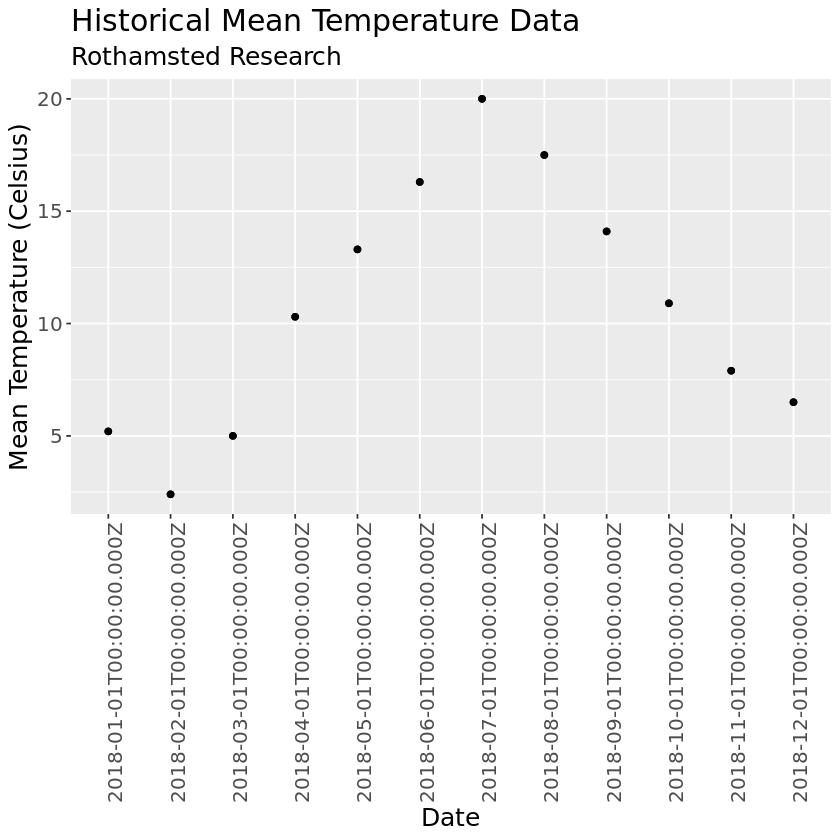

In [ ]:
# plot the mean temperature data observed for the area using ggplot
plot <- ggplot(data = meanTemp_spdf@data, aes(x = dateTime, y = value)) +
  geom_point() +
  labs(x = "Date",
    y = "Mean Temperature (Celsius)",
    title = "Historical Mean Temperature Data",
    subtitle = "Rothamsted Research") +
    theme(text = element_text(size=15), axis.text.x = element_text(angle = 90))  

print(plot)


### Conclusion
 
In this example, we have successfully retrieved geospatial data, with a time series, from our GraphQL query. We have then exported these time series data points into a single shapefile that can be used across a variety of GIS platforms and geospatial tools. 